# Email address disclosure analysis

In [1]:
import pandas as pd
import tldextract
import numpy as np
import hmac
from email_utils import *

## Read the data

In [2]:
emails = pd.read_pickle('../data/release/v1.0/corpus_v1.0.pkl')

In [3]:
emails.columns.values

array(['from_name', 'from_address', 'subject', 'body_text', 'uid', 'name',
       'office_sought', 'party_affiliation', 'office_level',
       'district_type', 'final_website', 'crawl_date', 'source', 'state',
       'type', 'subtype', 'date', 'hour', 'day', 'uid_email', 'uid_inbox',
       'incumbent'], dtype=object)

In [4]:
len(emails)

317366

Read in the index file for computing the names.

In [5]:
ifile = pd.read_csv('../data/release/v1.0/index_v1.0.csv')

## Compute the domain of the sender

In [6]:
def extract_tld(domain):
    extract = tldextract.extract(domain.lower())
    return extract.domain + '.' + extract.suffix

emails['from_address_domain'] = emails['from_address'].apply(lambda x: extract_tld(x.split('@')[1]) if '@' in x else x)

In [7]:
emails[~emails['from_address'].str.contains('@')]

,from_name,from_address,subject,body_text,uid,name,office_sought,party_affiliation,office_level,district_type,...,state,type,subtype,date,hour,day,uid_email,uid_inbox,incumbent,from_address_domain
178893,"Nikki Haley"" <senate@@TheDailyGrind.news>",,The future of the America First agenda is in Y...,Republican Senate candidates in battleground s...,af9dc0d488a4559cb8e987cfc218ae61,Tea Party PAC,NaN,NaN,NaN,NaN,...,NaN,Super PAC,NaN,2020-06-30,21,Tue,23b2e5f31b0a2d1e7b59ea9d6b4c380c,a29669159cad2526ebfc10718b6b3eaf,NaN,
188805,"Missed Message from Don Jr. (via NRCC)"" <membe...",,Election Update: WE WON AGAIN!,Top Conservatives like YOU are the reason we a...,53a466809dd0517783ffebbb8c137158,Tea Party PAC,NaN,NaN,NaN,NaN,...,NaN,Super PAC,NaN,2020-06-24,20,Wed,87063c19ad2a2b3cdfd29816cf61be30,a29669159cad2526ebfc10718b6b3eaf,NaN,
193188,TRUMP TOWNHALL TONIGHT at 9pm: 18 Patriots Nee...,,Trump Alert,The President needs to know that he has your s...,1165ef9302e85438a90491b74143fcfc,Tea Party PAC,NaN,NaN,NaN,NaN,...,NaN,Super PAC,NaN,2020-06-25,16,Thu,c4001b4a24141b6e80c0a27dbf9cecd2,a29669159cad2526ebfc10718b6b3eaf,NaN,
194270,"2020 Election Alerts"" <msc@@TheDailyGrind.news>",,Can you believe this?,Multiple recent polls have Joe Biden LEADING P...,06aaa3c7a5d1552cb5a3d0b6064126ba,Tea Party PAC,NaN,NaN,NaN,NaN,...,NaN,Super PAC,NaN,2020-07-07,15,Tue,c2bf30cf850a5cebd5438fe1bfc15962,a29669159cad2526ebfc10718b6b3eaf,NaN,
218153,,,Did you catch President Obama’s message?!,“Our country’s future hangs on this election.”...,3ff149685d1f598b81f87c4556f2ed06,Blue Wave Project,NaN,NaN,NaN,NaN,...,NaN,Leadership/Single-issue PAC,Leadership PAC,2020-08-21,12,Fri,444bad71e5e1b36c72d61bf0a19bb494,c8dc10ebcbe0d68113cbd98b18d83e86,NaN,
317208,State Rep Edie Hooton <>,,Please confirm your subscription,Thank you Alex for your interest in our newsle...,d2abe5b9aac55384bcc132f906bdf86e,Edie Hooton,Colorado House of Representatives District 10,Democratic Party,State,State Legislative (Lower),...,NaN,NaN,NaN,2020-05-27,16,Wed,2dee4b7ef6c3b0e7d5e2d96156950014,867fffc2f3332c5c835dd76b57691942,Yes,
322633,,,Trump Can't Stop Us from Voting,"Alex,\nPresident Trump’s sabotage of the US Po...",67329b2daa20559e96481e91190e69bc,Raquel Teran,Arizona House of Representatives District 30,Democratic Party,State,State Legislative (Lower),...,NaN,NaN,NaN,2020-08-15,15,Sat,447c84d43caf7faf73e997452c9dc8e3,9b4322b91ef3e0d7a206da0b1add4c11,Yes,


In [8]:
emails['from_address_domain']

0          kathleenformontana.com
1          kathleenformontana.com
2          kathleenformontana.com
3          kathleenformontana.com
4          kathleenformontana.com
                   ...           
324376                  gmail.com
324377                  gmail.com
324378            danmcentire.com
324379           bri4colorado.com
324380    mattreevesforsenate.com
Name: from_address_domain, Length: 317366, dtype: object

## Email sharing

In [9]:
def compile(x):
    final_website = set(x['final_website'].astype(str).to_list())
    if len(final_website) > 1:
        print('Error, investigate')
    else:
        final_website = final_website.pop()

    if final_website.startswith('https://www.'):
        final_website = final_website[12:]
    elif final_website.startswith('http://www.'):
        final_website = final_website[11:]
    elif final_website.startswith('https://'):
        final_website = final_website[8:]
    elif final_website.startswith('http://'):
        final_website = final_website[7:]
    elif final_website.startswith('www.'):
        final_website = final_website[4:]

    final_website = final_website.strip('/').strip()
    
    df = x[x['from_address_domain'] != final_website][['from_address', 'from_address_domain']].drop_duplicates()
    
    return df if len(df) > 0 else None

frame = emails.groupby('uid_inbox').apply(compile).reset_index().merge(ifile, on='uid_inbox', how='inner')[['uid_inbox', 'name', 'office_sought', 'type', 'subtype', 'party_affiliation', 'incumbent', 'office_level', 'district_type', 'source', 'from_address', 'from_address_domain','final_website']]

In [10]:
len(frame)

3424

In [11]:
frame.to_csv('../data/leaks/leaks.csv', index=False)

## Email sharing statistics

Read in the coded dataset

In [12]:
coded_frame = pd.read_csv('../data/leaks/leaks_coded.csv')

In [13]:
coded_frame = coded_frame[coded_frame['mailing_list'] == 'yes']

In [14]:
coded_frame.columns

Index(['to_address', 'office_sought', 'type', 'subtype', 'party_affiliation',
       'incumbent', 'office_level', 'district_type', 'source', 'name',
       'final_website', 'from_address', 'from_address_domain',
       'from_address_domain_type', 'from_address_org',
       'from_address_domain_office_level', 'mailing_list', 'notes'],
      dtype='object')

In [15]:
key = open('/Users/aruneshmathur/.ssh/id_rsa', 'rb').read()
coded_frame['uid_inbox'] = coded_frame.apply(lambda x: hmac.new(key, (x['to_address']).encode(), digestmod='md5').hexdigest(), axis=1)
del coded_frame['to_address']

In [16]:
coded_frame = coded_frame[['uid_inbox', 'office_sought', 'type', 'subtype', 'party_affiliation',
       'incumbent', 'office_level', 'district_type', 'source', 'name',
       'final_website', 'from_address_domain_office_level',
       'from_address_domain_type', 'from_address_org', 'mailing_list']]

In [17]:
len(coded_frame)

1306

In [18]:
len(coded_frame.drop_duplicates())

741

In [19]:
coded_frame = coded_frame.drop_duplicates()

In [20]:
coded_frame['source'].value_counts(dropna=False)

ballotpedia-campaign    565
orgs                    176
Name: source, dtype: int64

In [21]:
coded_frame[['uid_inbox', 'source', 'office_level']]['office_level'].value_counts(dropna=False)

Federal    443
NaN        176
State      122
Name: office_level, dtype: int64

In [22]:
coded_frame[['uid_inbox', 'source']].drop_duplicates()['source'].value_counts(dropna=False)

ballotpedia-campaign    258
orgs                     64
Name: source, dtype: int64

In [23]:
coded_frame[['uid_inbox', 'source', 'office_level']].drop_duplicates()['office_level'].value_counts(dropna=False)

Federal    168
State       90
NaN         64
Name: office_level, dtype: int64

In [24]:
coded_frame['from_address_domain_type'] = coded_frame['from_address_domain_type'].apply(lambda x: 'PAC' if 'PAC' in x else x)

In [25]:
def codify_origin(row):
    if row['source'] == 'ballotpedia-campaign':
        return row['office_level'] + ' Campaign'
        
    if 'PAC' in row['type']:
        return 'PAC'
    
    return row['type']

def codify_destination(row):
    if row['from_address_domain_type'] == 'Campaign':
        return row['from_address_domain_office_level'] + ' Campaign'
    else:
        return row['from_address_domain_type']

coded_frame['origin'] = coded_frame.apply(codify_origin, axis=1)
coded_frame['destination'] = coded_frame.apply(codify_destination, axis=1)

In [26]:
directions = (coded_frame['origin'] + ' -> ' + coded_frame['destination']).value_counts()
directions

Federal Campaign -> Federal Campaign                  173
Federal Campaign -> PAC                               125
PAC -> PAC                                             85
Federal Campaign -> Organization                       43
Federal Campaign -> State Campaign                     36
State Campaign -> State Campaign                       27
State Campaign -> Organization                         22
PAC -> Federal Campaign                                20
PAC -> Organization                                    19
State Campaign -> PAC                                  18
State Campaign -> Elected Official                     16
Federal Campaign -> State Political Party              15
Federal Campaign -> Political Committee                14
State Campaign -> Federal Campaign                     13
Federal Campaign -> Mailing List                       11
Federal Campaign -> Elected Official Campaign          10
PAC -> News                                             8
State Campaign

In [27]:
sources = ['Federal Campaign', 'PAC', 'State Campaign']
dests = ['Federal Campaign', 'PAC', 'Organization', 'Elected Official', '527 group', 'News', 'Mailing List', 'State Campaign', 'Elected Official Campaign']

coded_frame['origin_condensed'] = coded_frame['origin'].apply(lambda x: x if x in sources else 'Other')
coded_frame['destination_condensed'] = coded_frame['destination'].apply(lambda x: x if x in dests else 'Other')

In [28]:
directions = (coded_frame['origin_condensed'] + ' -> ' + coded_frame['destination_condensed']).value_counts()
directions

Federal Campaign -> Federal Campaign             173
Federal Campaign -> PAC                          125
PAC -> PAC                                        85
Federal Campaign -> Organization                  43
Federal Campaign -> Other                         42
Federal Campaign -> State Campaign                36
State Campaign -> State Campaign                  27
State Campaign -> Organization                    22
PAC -> Federal Campaign                           20
PAC -> Organization                               19
State Campaign -> PAC                             18
State Campaign -> Elected Official                16
State Campaign -> Other                           14
State Campaign -> Federal Campaign                13
Federal Campaign -> Mailing List                  11
Federal Campaign -> Elected Official Campaign     10
Other -> Federal Campaign                         10
PAC -> News                                        8
State Campaign -> 527 group                   

In [29]:
coded_frame['from_address_org'].value_counts()[:35]

Train democrats                                16
End Citizens United                            14
Progressive Turnout Project                    14
Stop Republicans PAC                           14
Congressional Black Caucus PAC                 12
Brady PAC                                      12
Progress Texas                                 11
Wendy Davis                                    11
Committee for Hispanic Causes-BOLD PAC         11
AmeriPAC: The Fund for a Greater America       10
Democratic Senatorial Campaign Committee       10
Mary Jennings "M.J." Hegar                     10
Congressional Progressive Caucus PAC            9
Candace Valenzuela                              8
House Majority PAC                              8
Let America Vote Victory Fund                   7
Save America Fund                               7
Joe Biden                                       7
Voter Protection Project                        7
Democratic Congressional Campaign Committee     6


In [30]:
coded_frame['name'].value_counts()[:35]

Evelyn Farkas                             20
Lulu Seikaly                              19
Sima Ladjevardian                         18
Sri Preston Kulkarni                      18
Sean Maloney                              14
Congressional Progressive Caucus PAC      14
Democratic Conservation Alliance          14
Elect Democratic Women                    13
Medicare for All PAC                      13
Let America Vote Victory Fund             13
TJ Cox                                    12
Marie Newman                              12
Ginger Bock                               10
Brynne Kennedy                             9
Committee for Hispanic Causes-BOLD PAC     9
Amanda Stuck                               9
Tea Party PAC                              9
Beth Doglio                                8
Harley Rouda                               8
Phil Arballo                               8
Scott Cooper                               7
Candace Valenzuela                         7
Great Amer

In [31]:
coded_frame['destination_condensed'].value_counts()[:35]

PAC                          230
Federal Campaign             216
Organization                  90
Other                         69
State Campaign                66
Mailing List                  21
Elected Official              16
Elected Official Campaign     14
News                          10
527 group                      9
Name: destination_condensed, dtype: int64

In [32]:
coded_frame['origin_condensed'].value_counts()[:35]

Federal Campaign    443
PAC                 146
State Campaign      122
Other                30
Name: origin_condensed, dtype: int64

## Sharing timeline

In [33]:
coded_frame = pd.read_csv('../data/leaks/leaks_coded.csv')
coded_frame = coded_frame[coded_frame['mailing_list'] == 'yes']

In [34]:
coded_frame.columns

Index(['to_address', 'office_sought', 'type', 'subtype', 'party_affiliation',
       'incumbent', 'office_level', 'district_type', 'source', 'name',
       'final_website', 'from_address', 'from_address_domain',
       'from_address_domain_type', 'from_address_org',
       'from_address_domain_office_level', 'mailing_list', 'notes'],
      dtype='object')

In [35]:
coded_frame['uid_inbox'] = coded_frame.apply(lambda x: hmac.new(key, (x['to_address']).encode(), digestmod='md5').hexdigest(), axis=1)
del coded_frame['to_address']

In [36]:
def get_date(row):
    uid_inbox = row['uid_inbox']
    from_address = row['from_address']
    
    date_shared = emails[(emails['from_address'] == from_address) & (emails['uid_inbox'] == uid_inbox)].sort_values('date', ascending=True)['date'].iloc[0]
    
    return date_shared
    
coded_frame['date_shared'] = coded_frame.apply(get_date, axis=1)

In [37]:
coded_frame = coded_frame.groupby(['uid_inbox', 'office_sought', 'type', 'subtype', 'party_affiliation',
                         'incumbent', 'office_level', 'district_type', 'source', 'name',
                         'final_website', 'from_address_domain_office_level',
                         'from_address_domain_type', 'from_address_org', 'mailing_list'], dropna=False).apply(lambda x: x.sort_values('date_shared', ascending=True)['date_shared'].iloc[0]).reset_index(name='date_shared')

In [38]:
coded_frame['crawl_date'] = coded_frame['uid_inbox'].apply(lambda x: emails[emails['uid_inbox'] == x]['crawl_date'].iloc[0])

In [39]:
coded_frame['crawl_date'] = pd.to_datetime(coded_frame['crawl_date'])
coded_frame['date_shared'] = pd.to_datetime(coded_frame['date_shared'])

In [40]:
coded_frame['days_before_share'] = (coded_frame['date_shared'] - coded_frame['crawl_date']).dt.days

Text(0, 0.5, 'Count')

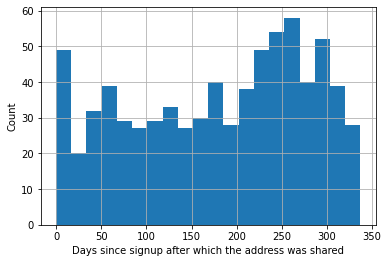

In [41]:
ax = coded_frame['days_before_share'].hist(bins = 20)
ax.set_xlabel('Days since signup after which the address was shared')
ax.set_ylabel('Count')

In [42]:
coded_frame['date_crawled_month'] = coded_frame['crawl_date'].dt.strftime('%Y-%m').astype(str)
coded_frame['date_shared_month'] = coded_frame['date_shared'].dt.strftime('%Y-%m').astype(str)

<AxesSubplot:>

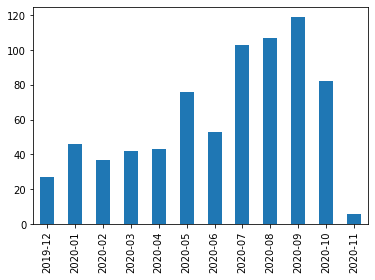

In [43]:
coded_frame['date_shared_month'].value_counts().sort_index().plot(kind='bar')

In [44]:
plotdf = coded_frame[['date_crawled_month', 'date_shared_month']].groupby(['date_crawled_month', 'date_shared_month']).size()

<AxesSubplot:xlabel='date_crawled_month', ylabel='date_shared_month'>

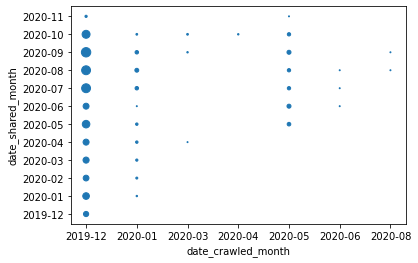

In [45]:
plotdf.reset_index(name='count').plot.scatter('date_crawled_month', 'date_shared_month', 'count')